# Uebung 4 Mehrklassenklassifikation mit Neuronalen Netzen


## Imports

In [224]:
import os
import csv
import cv2
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# Tensorflow imports for ResNet structure
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Model

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Globale Variablen
Definiere an dieser Stelle alle Variablen, die global verwendet werden, z.B.: Pfadnamen

In [71]:
# Define path to data
DATA_PATH = "../data/GTSRB/Final_Training/Images"

CLASS_ID_SIGN_MAP = "../data/GTSRB/Final_Training/tf_signs_mapping.csv"

## 1. Datenaufbereitung
Hinweise findest du hier: https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing

In [212]:
def readTrafficSigns(rootpath):
    """
    Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels
    
    """
    
    images = []
    labels = []
    
    # loop over all 42 classes
    for c in range(0,43):
        # subdirectory for class
        prefix = rootpath + '/' + format(c, '05d') + '/'
        
        # annotations file
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv')
        
        # csv parser for annotations file
        gtReader = csv.reader(gtFile, delimiter=';')
        
        # Skip header
        next(gtReader)
        
        # loop over all images in current annotations file
        for row in gtReader:
            # the 1th column is the filename
            images.append(plt.imread(prefix + row[0]))
            
            # the 8th column is the label
            labels.append(row[7])
            
        gtFile.close()
    
    return images, labels

def resizeImages(images, width=32, height=32):
    """
    Resize image to unify dimensions of the images
    
    """
    # Initialization
    unified_img = []
    normalized_img = []
    
    # Resize images
    for img in images:
        img = img.copy()
        unified_img.append(cv2.resize(img, (width, height)))
        
    # Normalize 
    for img in unified_img:
        R, G, B = cv2.split(img)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        normalized_img.append(cv2.merge((img_r, img_g, img_b)))
        
    print("Image Size: {} x {}".format(width, height))
        
    return normalized_img, width, height

def plotImages(X, labels, title, width=32, height=32):
    
    fig, axes = plt.subplots(
        3,15,
        figsize=(15,3),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i], cmap="gray")
        ax.text(2, 30, str(labels[i]), fontsize=15, c="white")
        
    fig.suptitle(title, fontsize=10)
    
def one_hot_encode(y):
    """
    Converts featuers from List of strings to one hot encoded labels
    """
    
    class_ids = y.astype(int)
    encoded = pd.get_dummies(class_ids).to_numpy()
    
    return encoded

def one_hot_decode(y, y_encoded):
    """
    Decodes one hot encoded data
    """
    
    class_ids = y.astype(int)
    decoded = pd.DataFrame(y_encoded).idxmax(1).astype(str).to_numpy()
    
    return decoded
        
def preprocessData(rootpath):
    """
    Loads the data and performs necessary preprocessing steps
    
    Parameters
    ----------
    path to the traffic sign data, for example './GTSRB/Training'
    
    Returns
    -------
    X_train : numpy.Array
    X_test  : numpy.Array
    y_tain  : numpy.Array
    y_test  : numpy.Array
    
    """
    
    # Load Data
    images, labels = readTrafficSigns(rootpath)
    colorNormalizationExample(images[25])
    
    # Unify image dimensions
    unified_img, max_width, max_height = resizeImages(images, width=32, height=32)
    
    # Convert list of labels to array of labels
    unified_img = np.array(unified_img)
    labels = np.array(labels)
    
    # 
    shuffle_indexes = np.arange(unified_img.shape[0])
    np.random.shuffle(shuffle_indexes)
    images_shuffled = unified_img[shuffle_indexes]
    labels_shuffled = labels[shuffle_indexes]
    
    # Perform train test split
    X_train, X_rest, y_train, y_rest = train_test_split(images_shuffled, labels_shuffled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


    # Save unformatted labels
    labels_train = y_train
    labels_val = y_val
    labels_test = y_test
    
    
    # One hot encode labels
    y_train = one_hot_encode(y_train)
    y_val = one_hot_encode(y_val)
    y_test = one_hot_encode(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test

def plotAugmentationExample(image, width=32, height=32):
    """
    Plots 8 augmented samples of an image
    
    Parameters
    ----------
    image : numpy.Array
        Examplary image
    width : Integer
        width of the image
    height : Integer
        heigth of the image
    
    """
    
    # Extract one example image
    image = image.copy()
    image = image.reshape(1, width, height, 3)

    # create image data augmentation generator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.3
    )

    # prepare iterator
    it = datagen.flow(image, batch_size=1)

    # Create figure
    fig, axes = plt.subplots(
        2,4,
        figsize=(15.8,8.2),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    for i, ax in enumerate(axes.flat):
        # generate batch of images
        batch = it.next()

        # convert to unsigned integers for viewing
        augmented_image = batch[0].astype('uint8')

        # Plot augmented image
        ax.imshow(augmented_image, cmap="gray")
        ax.text(2, 30, "sample_id = " + str(i), fontsize=25, c="white")

    #title = "Image augmentation example"
    #fig.suptitle(title, fontsize=30)
    
    filename = "figures/AumgentaionExample.png"
    plt.savefig(filename)

def colorNormalizationExample(image, width=32, height=32):
    
    img = image.copy()
    
    # Unified image
    unified_img = cv2.resize(img, (width, height))
        
    # Normalize 
    R, G, B = cv2.split(unified_img)
    img_r = cv2.equalizeHist(R)
    img_g = cv2.equalizeHist(G)
    img_b = cv2.equalizeHist(B)
    img_normalized = cv2.merge((img_r, img_g, img_b))
    
    fig, axes = plt.subplots(
        1,3,
        figsize=(19,5.5),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    axes[0].imshow(img)
    axes[0].set_title("Original", fontsize=30)
    
    axes[1].imshow(unified_img)
    axes[1].set_title("Skaliert", fontsize=30)
    
    axes[2].imshow(img_normalized)
    axes[2].set_title("Normalisierter Farbraum", fontsize=30)
    
    filename = "figures/ColorSpaceNormalization.png"
    plt.savefig(filename)
    
def plotDataHistogram(labels_train, labels_val, labels_test):
    
    labels_train_sorted = np.sort(labels_train.astype(int)).astype(str)
    labels_val_sorted = np.sort(labels_val.astype(int)).astype(str)
    labels_test_sorted = np.sort(labels_test.astype(int)).astype(str)
    
    fig, axes = plt.subplots(
        3,1,
        figsize=(15,9),
        #subplot_kw={'xticks':[], 'yticks':[]},
        #gridspec_kw=dict(hspace=0.01, wspace=0.01),
        dpi=120,
        sharex=True,
        constrained_layout=True
    )
    
    axes[0].hist(labels_train_sorted, bins=range(0,44))
    axes[0].set_title("Training", fontsize=18)
    
    axes[1].hist(labels_val_sorted, bins=range(0,44))
    axes[1].set_title("Validierung", fontsize=18)
    
    axes[2].hist(labels_test_sorted, bins=range(0,44))
    axes[2].set_title("Test", fontsize=18)

    plt.xlabel('Absolute Häufigkeit', fontsize=18)
    plt.ylabel('Klasse', fontsize=18)
    plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=15)
    
    
    

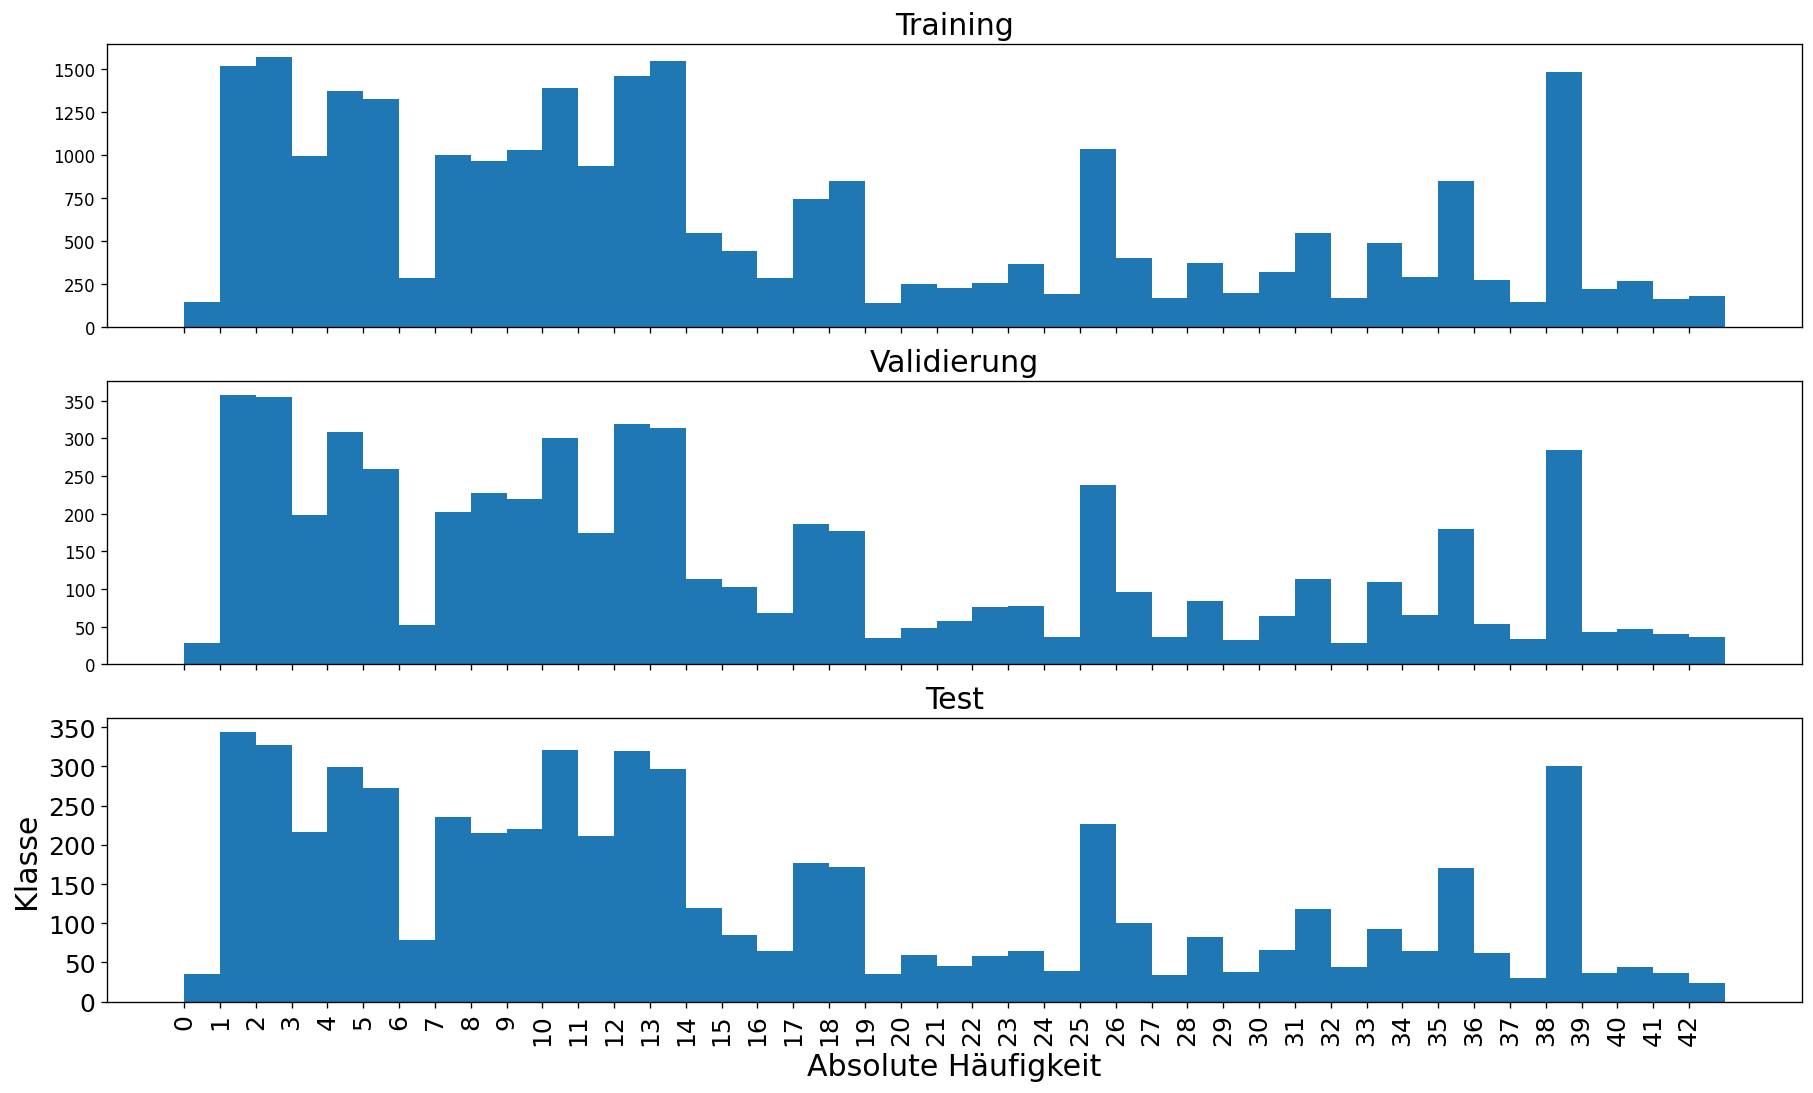

In [205]:
plotDataHistogram(labels_train, labels_val, labels_test)

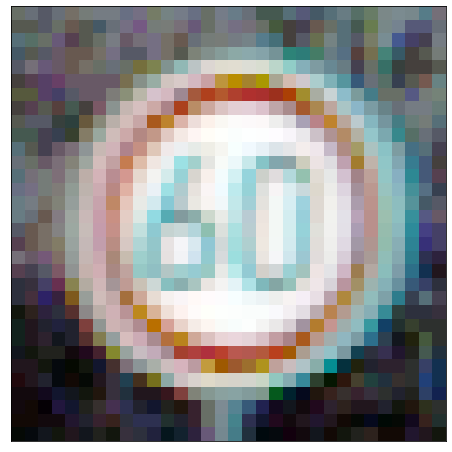

In [8]:
fig, axes = plt.subplots(
        1,1,
        figsize=(8,8),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

axes.imshow(X_val[8])

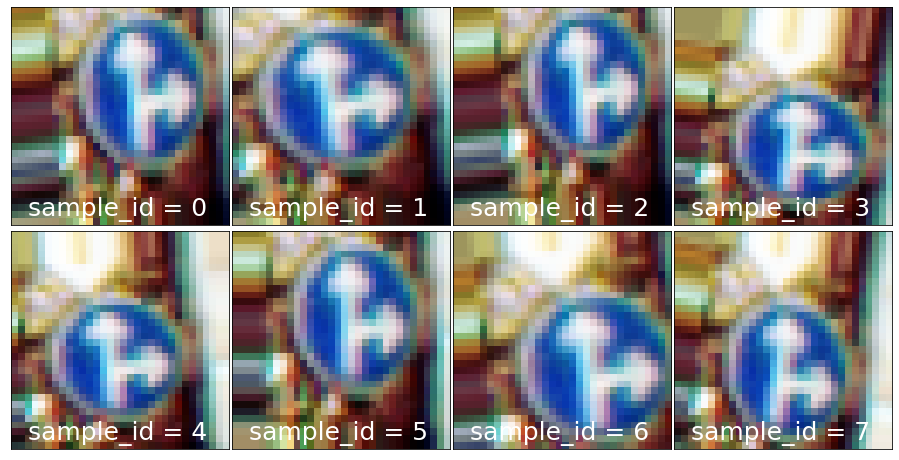

In [103]:
# Plot Augmentation Example
plotAugmentationExample(image=X_train[129])

Image Size: 32 x 32


/var/folders/0v/_s7dyyxx7w7191wrn82sg08m0000gn/T/ipykernel_1165/1746705465.py:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_ids = y.astype(np.int)


X_train.shape = (27446, 32, 32, 3)
y_tain.shape = (27446, 43)
X_val.shape = (5881, 32, 32, 3)
y_val.shape = (5881, 43)
X_test.shape = (5882, 32, 32, 3)
y_test.shape = (5882, 43)


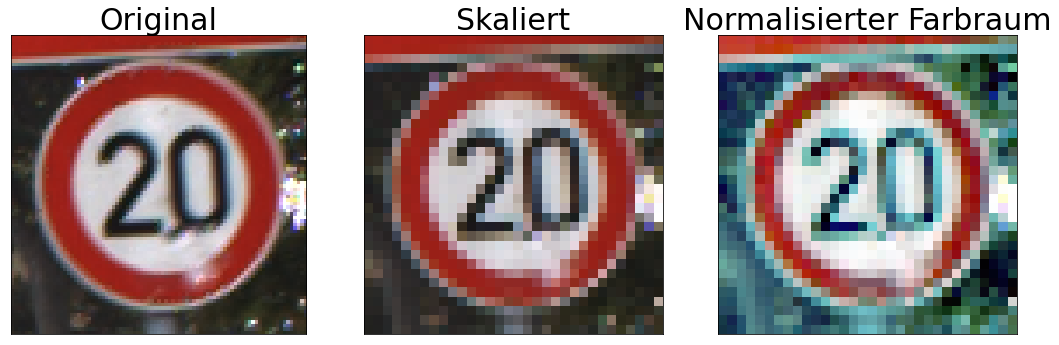

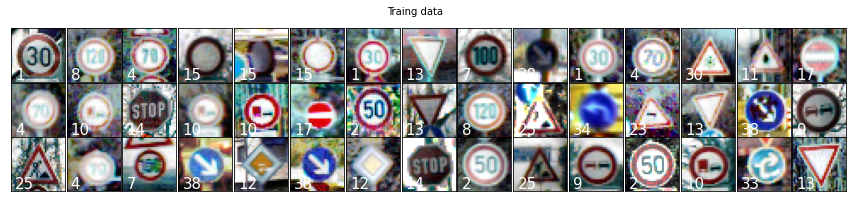

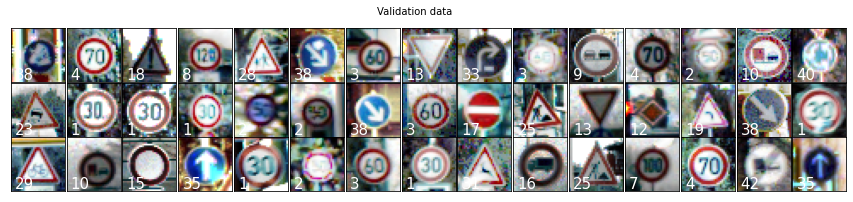

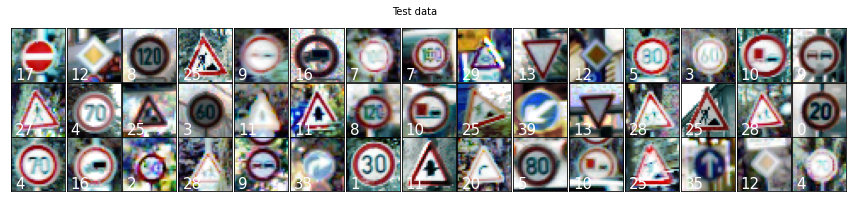

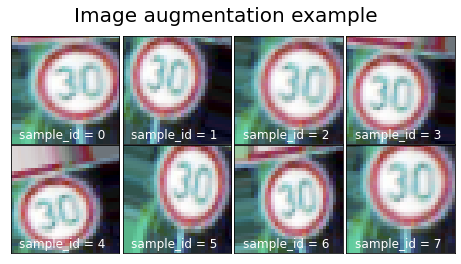

In [73]:
# Read all the Traffic Sign data
X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = preprocessData(DATA_PATH)

print("X_train.shape = {}".format(X_train.shape))
print("y_tain.shape = {}".format(y_train.shape))
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

# Plot first 44 examples of X_train and X_test
plotImages(X_train, labels_train, title="Traing data")
plotImages(X_val, labels_val, title="Validation data")
plotImages(X_test, labels_test, title="Test data")

# Plot Augmentation Example
plotAugmentationExample(image=X_train[125])

## 2.  Aufbau des Modells
Zum Aufbau deines Modells kannst du dich an die gezeigten Beispiele richten. Implementiere zuerst ein einfaches Modell, welches du je nach Performance erweitern kannst. 

Unten findest du die Auflistung der Schichten (Layers), die du für dein Modell miteinander kombinieren kannst. 


class RoadSignClassifier:Überlege dir, welche Layers für die Klassifikationsaufgabe mit HOG-Features gut sind und welche Layer sich für die Klassifikationsaufgabe mit ppm-Dateien eignen.

In [315]:
class RoadSignClassifier:
    """
    Classifier for 
    
    Attributes
    ----------
    self.name : String
        name of model
    width : Integer
        width of input images
    height : Integer
        heigth of input images
    depth : Integer
        

    

    """
    
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, N_classes, name):
        """
        Initialization of RoadSignClassifier instance
        
        """
        
        # Model name
        self.name = name
        
        # Dimensions of the data set
        self.width = X_train.shape[1]
        self.height = X_train.shape[2]
        self.depth = X_train.shape[3]
        
        # Data
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        
        # Labels
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.labels_train = None
        self.labels_test = None
        
        # Predicted Data
        self.y_test_pred = None
        self.labels_test_pred = None
        
        # Number of classes
        self.N_classes = N_classes
        
        # Instance of keras model
        self.model = None
        
        # Hyperparameters of model
        self.learning_rate = 0.001
        self.epochs = 20
        self.batch_size = 64
        self.patience = None
        self.drop_out_rate = 0.5
        
        # Augmentation Parameters
        self.use_augmentation = False
        self.rotation_range = 10
        self.zoom_range = 0.15
        self.width_shift_range = 0.1
        self.height_shift_range = 0.1
        self.shear_range = 0.15
        self.horizontal_flip = False
        self.vertical_flip = False
        
        # Training history
        self.training_hist = None
        
        # Best model
        self.initial_value_threshold = None
        
        # Evaluation
        self.classification_report_ = None
        self.test_accuracy = None
        self.confusion_matrix = None
        self.unique_labels = None
        

        
    
    def createModel(self):
        """
        Creates Sequential model using tensorflow keras
        """
        
        # Define input shape
        inputShape = (self.height, self.width, self.depth)
        
        # Initialize model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=inputShape, activation="relu"))
        
        model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=self.drop_out_rate))
        
        model.add(tf.keras.layers.Dense(self.N_classes, activation="softmax"))
        
        # Define optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.learning_rate, 
            decay=self.learning_rate / (self.epochs)
        )

        # Compile model
        model.compile(
            optimizer=optimizer, 
            loss="categorical_crossentropy", 
            metrics=["accuracy"]
        )
        
        self.model = model
        
        # Save weight initialization
        self.model.save_weights('models/' + self.name + '_initial.hdf5')
    
    def fit(self):
        """
        Definition of callbacks, specificaiton of data augmentation & fit of the model
        
        """
        
        # Specify early stopping criterion
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=self.patience,
            restore_best_weights=True
        )
        
        # Specify ModelCheckpoint to safe only model with minimal validation loss
        mcp_save = tf.keras.callbacks.ModelCheckpoint(
            filepath= 'models/' + self.name + '.hdf5', 
            save_best_only=True, 
            monitor='val_loss',
            initial_value_threshold=self.initial_value_threshold,
            mode='min'
        )


        # Perform data augmentation on the data, to increase the diversity of your training 
        # set by applying random (but realistic) transformations, such as image rotation.
        data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=self.rotation_range,
            zoom_range=self.zoom_range,
            width_shift_range=self.width_shift_range,
            height_shift_range=self.height_shift_range,
            shear_range=self.shear_range,
            horizontal_flip=self.horizontal_flip,
            vertical_flip=self.vertical_flip
        )
        
        # Fit model
        if self.use_augmentation:
            self.training_hist = self.model.fit(
                data_augmentation.flow(self.X_train, self.y_train, batch_size=self.batch_size),
                epochs=self.epochs,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stopping, mcp_save],
                verbose=1
            )
        else:
            self.training_hist = self.model.fit(
                self.X_train, 
                self.y_train, 
                batch_size=self.batch_size,
                epochs=self.epochs,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stopping, mcp_save],
                verbose=1
            )
        
        # Save model
        #self.model.save('models/' + self.name +)
    
    def gridSearch(self, batch_size_grid):
    
        # Initialize element to store best value in
        best_batch_size = None
        best_validation_loss = None
        best_model = None
        count = 0
        
        for batch_size in batch_size_grid:
            
            # Define batch size
            self.batch_size = batch_size
            
            # Reset weights
            self.model.load_weights('models/' + self.name + '_initial.hdf5')
            
            # Train Model
            print("*** batch_size = {} ***".format(self.batch_size))
            self.fit()
            
            if count == 0:
                # Get best validation loss
                best_validation_loss = min(self.training_hist.history['val_loss'])
                
                # Best batch size
                best_batch_size = self.batch_size
                
                # Best model
                best_model = self.model
                
                # training_hist of best model
                best_training_hist = self.training_hist
                
                # Set best validation loss as initial_value_threshold
                self.initial_value_threshold = best_validation_loss
                
                count +=1
                
            elif best_validation_loss > min(self.training_hist.history['val_loss']):
            
                best_validation_loss = min(self.training_hist.history['val_loss'])
                best_batch_size = self.batch_size
                best_model = self.model
                best_training_hist = self.training_hist
                self.initial_value_threshold = best_validation_loss
            
        # Overwrite model and training history with the one of the best model
        self.batch_size = best_batch_size
        self.training_hist = best_training_hist
        self.model = best_model 
        
        # Save grid search report as .txt file
        filename = "models/" + "grid_search_batch_size_report_" + clf.name + ".txt"
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print("batch_size_grid = {}".format(batch_size_grid), file=f)
            print("best_validation_loss = {}".format(best_validation_loss), file=f)
            print("*** Optimal Batch Size: {} ***".format(best_batch_size), file=f)
            
    def augmentationGridSearch(self):
    
        # Initialize counting variableto handle initial state
        count = 0
        
        # Define Augmentation range Grid
        rotation_range_grid = self.rotation_range
        zoom_range_grid = self.zoom_range
        width_shift_range_grid = self.width_shift_range
        height_shift_range_grid = self.height_shift_range
        shear_range_grid = self.shear_range
        
        # Get augmentation index grid
        augmentation_index_grid = range(0, len(rotation_range_grid))
        
        for augmentation_index in augmentation_index_grid:
            
            # Define augmentation range
            self.rotation_range = rotation_range_grid[augmentation_index]
            self.zoom_range = zoom_range_grid[augmentation_index]
            self.width_shift_range = width_shift_range_grid[augmentation_index]
            self.height_shift_range = height_shift_range_grid[augmentation_index]
            self.shear_range = shear_range_grid[augmentation_index]
            
            # Reset weights (The result from the best model of batch size grid search is being selected as initialization)
            self.model.load_weights('models/model_1.hdf5')
            
            # Train Model
            print("*** augmentation_index = {} ***".format(augmentation_index))
            self.fit()
            
            if count == 0:
                # Get best validation loss
                best_validation_loss = min(self.training_hist.history['val_loss'])
                
                # Best batch size
                best_augmentation_index = augmentation_index
                
                # Best model
                best_model = self.model
                
                # training_hist of best model
                best_training_hist = self.training_hist
                
                # Set best validation loss as initial_value_threshold
                self.initial_value_threshold = best_validation_loss
                
                count +=1
                
            elif best_validation_loss > min(self.training_hist.history['val_loss']):
            
                best_validation_loss = min(self.training_hist.history['val_loss'])
                best_augmentation_index = augmentation_index
                best_model = self.model
                best_training_hist = self.training_hist
                self.initial_value_threshold = best_validation_loss
            
        # Overwrite model and training history with the one of the best model
        self.rotation_range = rotation_range_grid[best_augmentation_index]
        self.zoom_range = zoom_range_grid[best_augmentation_index]
        self.width_shift_range = width_shift_range_grid[best_augmentation_index]
        self.height_shift_range = height_shift_range_grid[best_augmentation_index]
        self.shear_range = shear_range_grid[best_augmentation_index]
        self.training_hist = best_training_hist
        self.model = best_model 
        
        # Save grid search report as .txt file
        filename = "models/" + "grid_search_augmentation_report_" + clf.name + ".txt"
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print("--- PARAMETER SPACE ---", file=f)
            print("rotation_range_grid = {}".format(rotation_range_grid), file=f)
            print("zoom_range_grid = {}".format(zoom_range_grid), file=f)
            print("width_shift_range_grid = {}".format(width_shift_range_grid), file=f)
            print("height_shift_range_grid = {}".format(height_shift_range_grid), file=f)
            print("shear_range_grid = {}".format(shear_range_grid), file=f)
            
            print("--- OPTIMAL PARAMETER ---", file=f)
            print("rotation_range = {}".format(self.rotation_range), file=f)
            print("zoom_range = {}".format(self.zoom_range), file=f)
            print("width_shift_range = {}".format(self.width_shift_range), file=f)
            print("height_shift_range = {}".format(self.height_shift_range), file=f)
            print("shear_range = {}".format(self.shear_range), file=f)
            
            print("\nbest_validation_loss = {}".format(best_validation_loss), file=f)
            
    def dropOutGridSearch(self, drop_out_rate_grid):
    
        # Initialize counting variableto handle initial stat
        count = 0
        
        for drop_out_rate in drop_out_rate_grid:
            
            # Define batch size
            self.drop_out_rate = drop_out_rate
            
            # Create Model with given drop out rate
            self.createModel()
            self.model.summary()
            
            # Reset weights
            self.model.load_weights('models/model_1_initial.hdf5')
            
            # Train Model
            print("*** drop_out_rate = {} ***".format(self.drop_out_rate))
            self.fit()
            
            if count == 0:
                # Get best validation loss
                best_validation_loss = min(self.training_hist.history['val_loss'])
                
                # Best batch size
                best_drop_out_rate = self.drop_out_rate
                
                # Best model
                best_model = self.model
                
                # training_hist of best model
                best_training_hist = self.training_hist
                
                # Set best validation loss as initial_value_threshold
                self.initial_value_threshold = best_validation_loss
                
                count +=1
                
            elif best_validation_loss > min(self.training_hist.history['val_loss']):
                best_validation_loss = min(self.training_hist.history['val_loss'])
                best_drop_out_rate = self.drop_out_rate
                best_model = self.model
                best_training_hist = self.training_hist
                self.initial_value_threshold = best_validation_loss
            
        # Overwrite model and training history with the one of the best model
        self.drop_out_rate = best_drop_out_rate
        self.training_hist = best_training_hist
        self.model = best_model 
        
        # Save grid search report as .txt file
        filename = "models/" + "grid_search_drop_out_report_" + clf.name + ".txt"
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print("dropout_rate_grid = {}".format(drop_out_rate_grid), file=f)
            print("best_validation_loss = {}".format(best_validation_loss), file=f)
            print("*** Optimal Drop Out Rate: {} ***".format(best_drop_out_rate), file=f)
        
        
    def evaluate(self):
        """
        Performs evaluation of the model based on test accuracy and confusion matrix
        
        """
        
        # Predict Test data
        self.y_test_pred = clf_4.model.predict(clf_4.X_test)
        
        # Decode predicted one-hot-encoded labels
        self.labels_test_pred = one_hot_decode(clf_4.labels_test, clf_4.y_test_pred)
        
        # Compute classification report
        self.classification_report_ = classification_report(
            self.labels_test.astype(int), 
            self.labels_test_pred.astype(int)
        )
        print(clf_4.classification_report_)
                                           
        # Evalueate trained model with test data
        loss, self.test_accuracy = self.model.evaluate(
            self.X_test,
            self.y_test,
            verbose=0
        )
        
        # Compute Confusion Matrix
        y_true = self.labels_test
        y_pred = self.labels_test_pred
        self.unique_labels = np.unique(self.labels_test.astype(int)).astype(str)
        self.confusion_matrix = confusion_matrix(y_true, y_pred, labels=self.unique_labels)
        
        # Save classification report as .txt file
        filename = "models/" + "report_" + self.name
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print(clf_4.classification_report_, file=f)
            print("Test loss = {}".format(loss), file=f)
            print("Test accuracy = {}".format(self.test_accuracy), file=f)
    
    def plotLossHistory(self):
        """
        Plots training history
        
        """
        loss_history = self.training_hist.history['loss']
        validation_loss = self.training_hist.history['val_loss']
        
        fontsize = 12

        %matplotlib inline
        plt.figure(dpi=90)
        plt.semilogy(loss_history)
        plt.semilogy(validation_loss)
        plt.title("Loss Kurve {}".format(clf.name), fontsize=fontsize)
        plt.xlabel("Epoch", fontsize=fontsize)
        plt.ylabel("Loss", fontsize=fontsize)
        plt.legend(['loss', 'validation_loss'], fontsize=fontsize)
        
        # Save figure
        filename = "figures/traning_hist_" + clf.name + ".png"
        plt.savefig(filename)
        plt.show()

### 2.1 CNN - Hyper Parameter Optimization

#### 2.1.1 Selection of Batch size via grid search

In [105]:
clf_1 = RoadSignClassifier(X_train, X_val, X_test, y_train, y_val, y_test, N_classes=43, name="model_1")

# Labels
clf_1.labels_train = labels_train
clf_1.labels_val = labels_val
clf_1.labels_test = labels_test

# Set hyperparameters of model
clf_1.learning_rate = 0.001
clf_1.epochs = 50
clf_1.patience = 20

# Set augmentation Parameters
clf_1.use_augmentation = False
clf_1.rotation_range = 10
clf_1.zoom_range = 0.15
clf_1.width_shift_range = 0.1
clf_1.height_shift_range = 0.1
clf_1.shear_range = 0.15
clf_1.horizontal_flip = False
clf_1.vertical_flip = False

# Create Model
clf_1.createModel()
clf_1.model.summary()

clf_1.gridSearch(batch_size_grid=[16, 64, 256])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_93 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_69 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_94 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_95 (Conv2D)          (None, 10, 10, 128)     

Epoch 40/50
1716/1716 [==============================] - 52s 30ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0135 - val_accuracy: 0.9978
Epoch 41/50
1716/1716 [==============================] - 55s 32ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0153 - val_accuracy: 0.9968
Epoch 42/50
1716/1716 [==============================] - 55s 32ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0172 - val_accuracy: 0.9973
Epoch 43/50
1716/1716 [==============================] - 54s 31ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0162 - val_accuracy: 0.9974
Epoch 44/50
1716/1716 [==============================] - 57s 33ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0126 - val_accuracy: 0.9968
Epoch 45/50
1716/1716 [==============================] - 56s 33ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0156 - val_accuracy: 0.9971
Epoch 46/50
1716/1716 [==============================] - 55s 32ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0

Epoch 46/50
429/429 [==============================] - 36s 83ms/step - loss: 6.4417e-04 - accuracy: 0.9999 - val_loss: 0.0132 - val_accuracy: 0.9964
Epoch 47/50
429/429 [==============================] - 36s 83ms/step - loss: 3.0570e-04 - accuracy: 0.9999 - val_loss: 0.0106 - val_accuracy: 0.9971
Epoch 48/50
429/429 [==============================] - 36s 84ms/step - loss: 1.0452e-04 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9973
Epoch 49/50
429/429 [==============================] - 37s 87ms/step - loss: 1.1284e-04 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9969
Epoch 50/50
429/429 [==============================] - 37s 85ms/step - loss: 1.8412e-04 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9964
*** batch_size = 256 ***
Epoch 1/50
108/108 [==============================] - 28s 258ms/step - loss: 0.4959 - accuracy: 0.8694 - val_loss: 0.3729 - val_accuracy: 0.9424
Epoch 2/50
108/108 [==============================] - 26s 243ms/step - loss: 0.0387 -

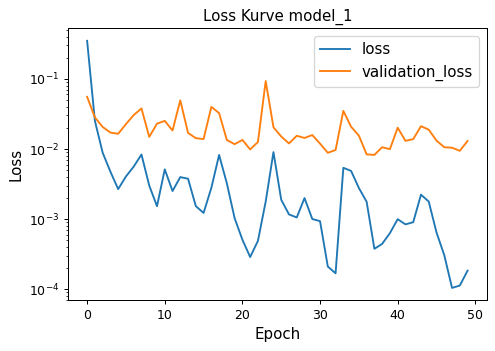

184/184 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.71      0.81        35
           1       0.89      0.80      0.84       344
           2       0.78      0.88      0.83       327
           3       0.99      0.59      0.74       217
           4       0.90      0.91      0.91       299
           5       1.00      0.04      0.08       272
           6       0.78      0.99      0.87        79
           7       0.95      0.59      0.73       236
           8       1.00      0.20      0.33       215
           9       0.95      0.96      0.96       220
          10       0.98      0.93      0.95       321
          11       0.77      0.97      0.86       211
          12       1.00      0.87      0.93       320
          13       0.34      1.00      0.51       297
          14       1.00      0.97      0.99       119
          15       0.79      0.81      0.80        85
          16       0.82  

/var/folders/0v/_s7dyyxx7w7191wrn82sg08m0000gn/T/ipykernel_1165/2195510918.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_ids = y.astype(np.int)
/Users/stefankuhn/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefankuhn/.pyenv/versions/3.8.6/lib/python3.8/s

In [106]:
# Plot loss history
clf_1.plotLossHistory()

# Evaluate Model
clf_1.evaluate()

#### 2.1.2 Selection of level of augmentation

In [114]:
clf_2 = RoadSignClassifier(X_train, X_val, X_test, y_train, y_val, y_test, N_classes=43, name="model_2")

# Labels
clf_2.labels_train = labels_train
clf_2.labels_val = labels_val
clf_2.labels_test = labels_test

# Set hyperparameters of model
clf_2.learning_rate = 0.001
clf_2.epochs = 50
clf_2.batch_size = clf_1.batch_size
clf_2.patience = 20

# Set augmentation Parameters
clf_2.use_augmentation = True
clf_2.rotation_range = [5, 10, 20]
clf_2.zoom_range = [0.05, 0.1, 0.2]
clf_2.width_shift_range = [0.05, 0.1, 0.2]
clf_2.height_shift_range = [0.05, 0.1, 0.2]
clf_2.shear_range = [0.05, 0.1, 0.2]
clf_2.horizontal_flip = False
clf_2.vertical_flip = False

# Create Model
clf_2.createModel()
clf_2.model.summary()

# Perform Grid search on level of augmentation
clf_2.augmentationGridSearch()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 30, 30, 16)        448       
                                                                 
 conv2d_101 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_75 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_102 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_103 (Conv2D)         (None, 10, 10, 128)     

KeyboardInterrupt: 

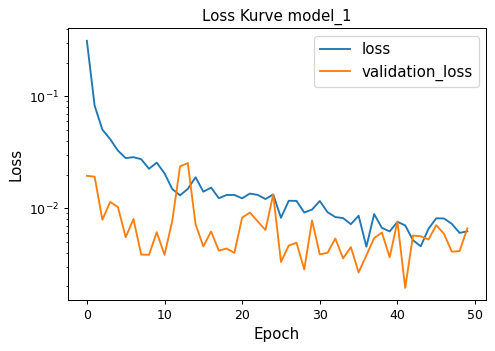

184/184 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.71      0.81        35
           1       0.89      0.80      0.84       344
           2       0.78      0.88      0.83       327
           3       0.99      0.59      0.74       217
           4       0.90      0.91      0.91       299
           5       1.00      0.04      0.08       272
           6       0.78      0.99      0.87        79
           7       0.95      0.59      0.73       236
           8       1.00      0.20      0.33       215
           9       0.95      0.96      0.96       220
          10       0.98      0.93      0.95       321
          11       0.77      0.97      0.86       211
          12       1.00      0.87      0.93       320
          13       0.34      1.00      0.51       297
          14       1.00      0.97      0.99       119
          15       0.79      0.81      0.80        85
          16       0.82  

/var/folders/0v/_s7dyyxx7w7191wrn82sg08m0000gn/T/ipykernel_1165/2195510918.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_ids = y.astype(np.int)
/Users/stefankuhn/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefankuhn/.pyenv/versions/3.8.6/lib/python3.8/s

In [108]:
# Plot loss history
clf_2.plotLossHistory()

# Evaluate Model
clf_2.evaluate()

#### 2.1.3 Drop Out Rate Grid search

In [121]:
clf_3 = RoadSignClassifier(X_train, X_val, X_test, y_train, y_val, y_test, N_classes=43, name="model_2")

# Labels
clf_3.labels_train = labels_train
clf_3.labels_val = labels_val
clf_3.labels_test = labels_test

# Set hyperparameters of model
clf_3.learning_rate = 0.001
clf_3.epochs = 50
clf_3.batch_size = clf_1.batch_size
clf_3.patience = 20

# Set augmentation Parameters
clf_3.use_augmentation = True
clf_3.rotation_range = clf_2.rotation_range
clf_3.zoom_range = clf_2.zoom_range
clf_3.width_shift_range = clf_2.width_shift_range
clf_3.height_shift_range = clf_2.height_shift_range
clf_3.shear_range = clf_2.shear_range
clf_3.horizontal_flip = False
clf_3.vertical_flip = False

# Perform Grid search on level of augmentation
clf_3.dropOutGridSearch(drop_out_rate_grid=[0.3, 0.4, 0.5])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 30, 30, 16)        448       
                                                                 
 conv2d_121 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_90 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_122 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_123 (Conv2D)         (None, 10, 10, 128)     

429/429 [==============================] - 41s 95ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0070 - val_accuracy: 0.9986
Epoch 32/50
429/429 [==============================] - 41s 95ms/step - loss: 0.0068 - accuracy: 0.9976 - val_loss: 0.0093 - val_accuracy: 0.9976
Epoch 33/50
429/429 [==============================] - 41s 95ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 34/50
429/429 [==============================] - 41s 95ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0059 - val_accuracy: 0.9983
Epoch 35/50
429/429 [==============================] - 41s 95ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0043 - val_accuracy: 0.9991
Epoch 36/50
429/429 [==============================] - 41s 95ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 37/50
429/429 [==============================] - 41s 95ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.0168 - val_accuracy: 0.99

In [302]:
clf_4 = RoadSignClassifier(X_train, X_val, X_test, y_train, y_val, y_test, N_classes=43, name="model_4")

# Labels
clf_4.labels_train = labels_train
clf_4.labels_val = labels_val
clf_4.labels_test = labels_test

# Set hyperparameters of model
clf_4.learning_rate = 0.001
clf_4.epochs = 200
clf_4.batch_size = clf_1.batch_size
clf_4.patience = 30
clf_4.drop_out_rate = 0.5

# Set augmentation Parameters
clf_4.use_augmentation = True
clf_4.rotation_range = clf_2.rotation_range
clf_4.zoom_range = clf_2.zoom_range
clf_4.width_shift_range = clf_2.width_shift_range
clf_4.height_shift_range = clf_2.height_shift_range
clf_4.shear_range = clf_2.shear_range
clf_4.horizontal_flip = False
clf_4.vertical_flip = False

clf_4.createModel()
clf_4.model.summary()

clf_4.fit()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 30, 30, 16)        448       
                                                                 
 conv2d_145 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_108 (Ba  (None, 14, 14, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_146 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_147 (Conv2D)         (None, 10, 10, 128)     

429/429 [==============================] - 43s 99ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0106 - val_accuracy: 0.9968
Epoch 41/200
429/429 [==============================] - 44s 101ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0063 - val_accuracy: 0.9981
Epoch 42/200
429/429 [==============================] - 42s 98ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0084 - val_accuracy: 0.9973
Epoch 43/200
429/429 [==============================] - 43s 100ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0078 - val_accuracy: 0.9978
Epoch 44/200
429/429 [==============================] - 41s 96ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0080 - val_accuracy: 0.9981
Epoch 45/200
429/429 [==============================] - 41s 95ms/step - loss: 0.0046 - accuracy: 0.9982 - val_loss: 0.0154 - val_accuracy: 0.9956
Epoch 46/200
429/429 [==============================] - 41s 97ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0189 - val_accura

In [314]:
loss_history = clf_4.training_hist.history['loss']
validation_loss = clf_4.training_hist.history['val_loss']

loss_history_df = pd.DataFrame({'loss': loss_history, 'cal_loss': validation_loss})
loss_history_df.to_csv('model_4_loss_history.csv')

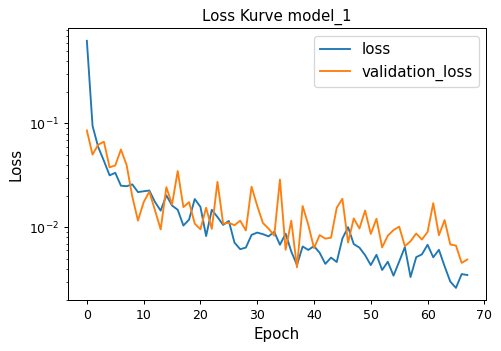

184/184 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00       344
           2       1.00      1.00      1.00       327
           3       1.00      1.00      1.00       217
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       272
           6       1.00      1.00      1.00        79
           7       1.00      1.00      1.00       236
           8       1.00      1.00      1.00       215
           9       1.00      1.00      1.00       220
          10       1.00      1.00      1.00       321
          11       1.00      1.00      1.00       211
          12       1.00      1.00      1.00       320
          13       1.00      1.00      1.00       297
          14       1.00      1.00      1.00       119
          15       1.00      1.00      1.00        85
          16       0.98  

AttributeError: 'RoadSignClassifier' object has no attribute 'classification_report'

In [320]:
# Plot loss history
clf_4.plotLossHistory()

# Evaluate Model
clf_4.evaluate()

In [321]:
with open("report_model_4", "a") as f:
    print(clf_4.classification_report_, file=f)
    print("Test accuracy = {}".format(clf_4.test_accuracy), file=f)

In [ ]:
clf_4.test_accuracy

#### 2.2.1 Training of final model

In [258]:
clf_5 = RoadSignClassifier(X_train, X_val, X_test, y_train, y_val, y_test, N_classes=43, name="model_5")

# Labels
clf_5.labels_train = labels_train
clf_5.labels_val = labels_val
clf_5.labels_test = labels_test

# Set hyperparameters of model
clf_5.learning_rate = 0.001
clf_5.epochs = 3
clf_5.batch_size = clf_1.batch_size
clf_5.patience = 30
clf_5.drop_out_rate = 0.5

# Set augmentation Parameters
clf_5.use_augmentation = True
clf_5.rotation_range = clf_2.rotation_range
clf_5.zoom_range = clf_2.zoom_range
clf_5.width_shift_range = clf_2.width_shift_range
clf_5.height_shift_range = clf_2.height_shift_range
clf_5.shear_range = clf_2.shear_range
clf_5.horizontal_flip = False
clf_5.vertical_flip = False

clf_5.createModel()
clf_5.model.summary()

clf_5.fit()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 30, 30, 16)        448       
                                                                 
 conv2d_141 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_105 (Ba  (None, 14, 14, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_142 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_143 (Conv2D)         (None, 10, 10, 128)     

<AxesSubplot:title={'center':'Confusion matrix with ony false classificaitons'}>

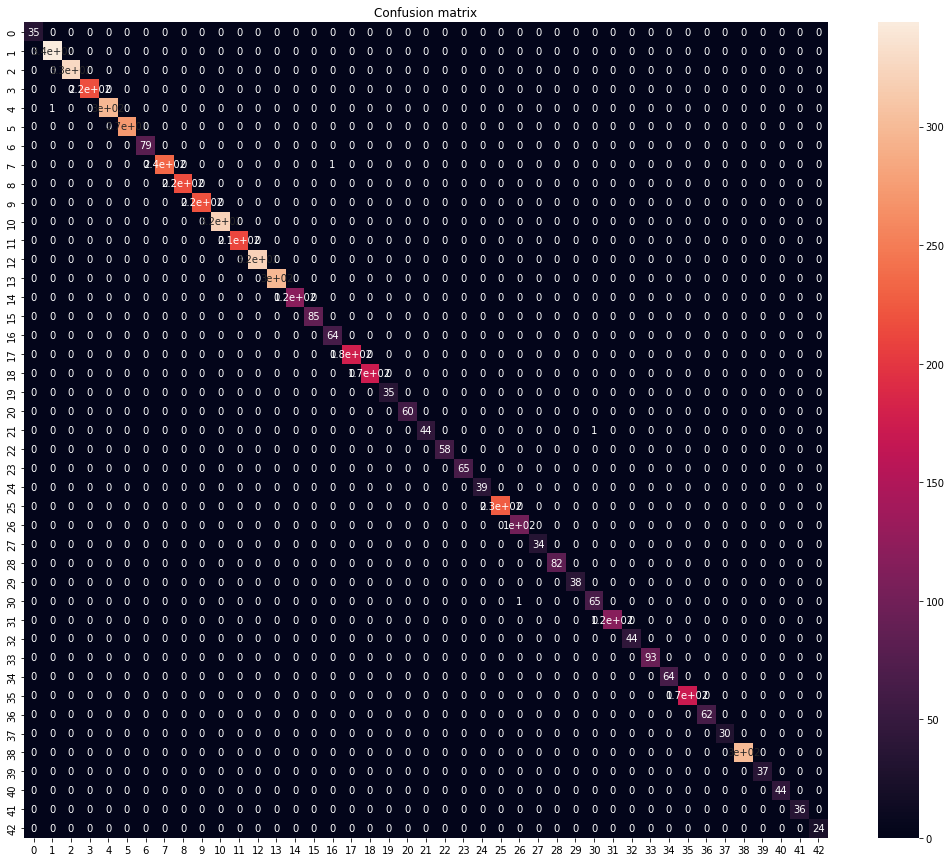

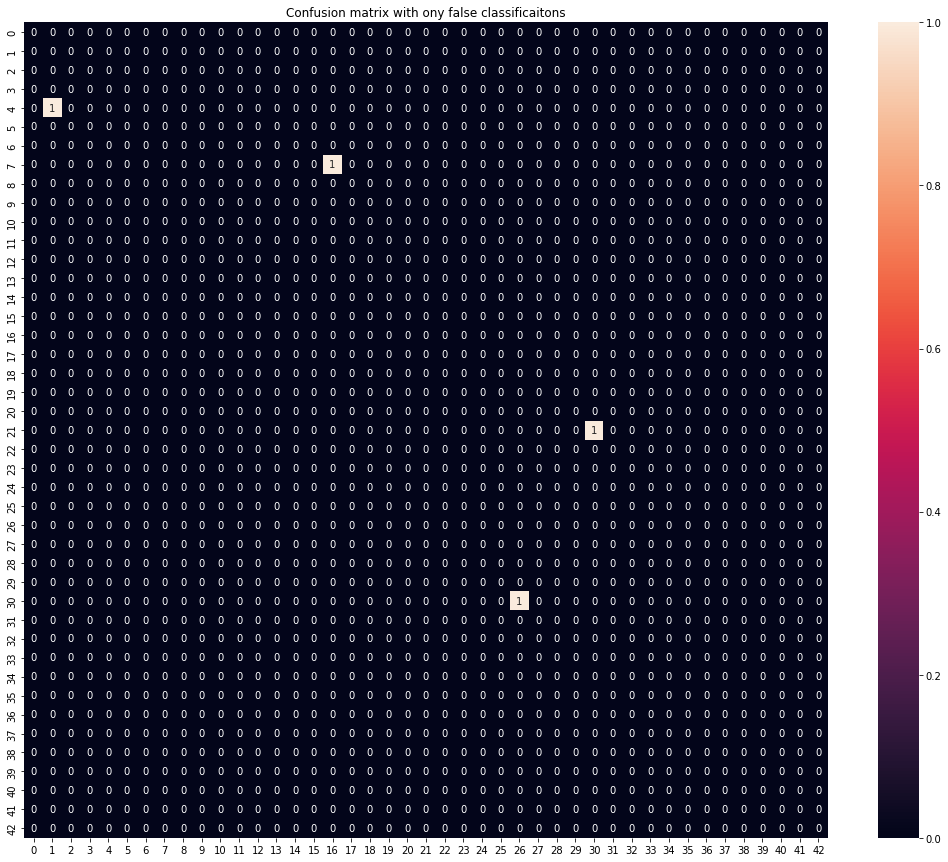

In [322]:
# Define confusion matrix
conf_matrix = clf_4.confusion_matrix
unique_labels = clf_4.unique_labels

# Plot confusion matrix
df_cm = pd.DataFrame(conf_matrix, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True)


# Plot matrix of only false classifications
conf_matrix_normalized = conf_matrix - np.diag(conf_matrix) * np.eye(len(conf_matrix))
df_cm_normalized = pd.DataFrame(conf_matrix_normalized, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix with ony false classificaitons")
sn.heatmap(df_cm_normalized, annot=True)

In [327]:
labels_test.shape

(5882,)